# Tutorial for running the Python Optimization Toolbox (POPT)

<font size=4em>As an illustrative example we choose a 2D-field with one producer and two (water) injectors. The figure below shows the permeability field and the well positions. The grid is 100x100, and the porosity is 0.18. The optimization problem is to find the pressure control for the wells in order to maximize net present value. 

<img src="permx.png" alt="drawing" width="500"/>
    
<br>
<font size=4em>The first step is to load neccessary external and local modules. 

In [1]:
# Import global modules
import os
import glob
import shutil
import logging
from glob import glob
from copy import deepcopy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt  
from scipy.stats import expon

# Import local modules
from input_output import read_config # functions for reading input
from popt.misc_tools import optim_tools as ot # help functions for optimization
from popt.loop.optimize import Optimize # The Optimize class contains the iterative loop
from popt.loop.ensemble import Ensemble # the Ensemble class contains the objective function
from simulator.opm import flow # the simulator we want to use
from popt.update_schemes.enopt import EnOpt # the standard EnOpt method
from popt.update_schemes.smcopt import SmcOpt # the sequential Monte Carlo method
from popt.cost_functions.npv import npv # the cost function

<font size=4em>Set the random seed:

In [2]:
np.random.seed(101122)    

<font size=4em>The plottting function is used to display the objective function vs. iterations for different methods:

In [3]:
def plot_obj_func():
    
    # Collect all results
    path_to_files = './'
    path_to_figures = './'  # Save here
    if not os.path.exists(path_to_figures):
        os.mkdir(path_to_figures)
    files = os.listdir(path_to_files)
    results = [name for name in files if "optimize_result" in name]
    num_iter = len(results)

    mm = []
    for iter in range(num_iter):
        info = np.load(str(path_to_files) + 'optimize_result_{}.npz'.format(iter))
        if 'best_func' in info:
            mm.append(-info['best_func'])
        else:
            mm.append(-info['obj_func_values'])

    f = plt.figure()
    plt.plot(mm, 'bs-')
    plt.xticks(range(num_iter))
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('Iteration no.', size=14)
    plt.ylabel('NPV', size=14)
    plt.title('Objective function', size=14)
    f.tight_layout(pad=2.0)
    plt.show()

<font size=4em>Remove old results and folders, if present:

In [4]:
for folder in glob('En_*'):
    shutil.rmtree(folder)
for file in glob('optimize_result_*'):
    os.remove(file)

<font size=4em>Read inputfile. In this tutorial the input file is written as a .toml file, and consists of three main keys: <span style="font-family:Courier;">ensemble</span>, <span style="font-family:Courier;">optim</span> and <span style="font-family:Courier;">fwdsim</span>. The first part contains keys related to the ensemble, the second part contains the options for the optimization algorithm and the third part are options related to the forward simulation model and objective function.

In [5]:
!cat init_optim.toml
ko, kf, ke = read_config.read_toml('init_optim.toml')

[ensemble]
disable_tqdm = true
ne = 10
state = ["injbhp","prodbhp"]
prior_injbhp = [
    ["mean","init_injbhp.npz"],
    ["var",6250.0],
    ["limits",100.0,500.0]
]
prior_prodbhp = [
    ["mean","init_prodbhp.npz"],
    ["var",6250.0,],
    ["limits",20.0,300.0]
]
num_models = 1
transform = true

[optim]
maxiter = 5
tol = 1e-06
alpha = 0.2
beta = 0.1
alpha_maxiter = 3
resample = 0
optimizer = 'GA'
nesterov = true
restartsave = true
restart = false
hessian = false
inflation_factor = 10
savedata = ["alpha","obj_func_values"]

[fwdsim]
npv_const = [
    ["wop",283.05],
    ["wgp",0.0],
    ["wwp",37.74],
    ["wwi",12.58],
    ["disc",0.08],
    ["obj_scaling",-1.0e6]
]
parallel = 5
simoptions = ['sim_flag', '--parsing-strictness=low']
runfile = "3well"
reportpoint = [
    1994-02-09 00:00:00,
    1995-01-01 00:00:00,
    1996-01-01 00:00:00,
    1997-01-01 00:00:00,
    1998-01-01 00:00:00,
    1999-01-01 00:00:00,
]
reporttype = "dates"
datatype = ["fopt","fgpt","fwpt","fwit"]


<font size=4em>Set initial pressure (note that the filenames correspond to the names given in the input file above):

In [6]:
init_injbhp = np.array([300.0,250.0])
init_prodbhp = np.array([100.0])
np.savez('init_injbhp.npz', init_injbhp)
np.savez('init_prodbhp.npz', init_prodbhp)

<font size=4em>Initialize the simulator with simulator keys.

In [7]:
sim = flow(kf)
print(flow.__init__.__doc__)


        The inputs are all optional, but in the same fashion as the other simulators a system must be followed.
        The input_dict can be utilized as a single input. Here all nescessary info is stored. Alternatively,
        if input_dict is not defined, all the other input variables must be defined.

        Parameters
        ----------
        input_dict : dict, optional
            Dictionary containing all information required to run the simulator.

                - parallel: number of forward simulations run in parallel
                - simoptions: options for the simulations
                    - sim_path: Path to the simulator
                    - sim_flag: Flags sent to the simulator (see simulator documentation for all possibilities)
                - runfile: name of the simulation input file
                - reportpoint: these are the dates the simulator reports results
                - reporttype: this key states that the report poins are given as dates
         

<font size=4em>Initialize the ensemble with ensemble keys, the simulator, and the chosen objective function. Here we also extract the initial state (x0), the covariance (cov), and the bounds. 

In [8]:
ensemble = Ensemble(ke, sim, npv)
print(Ensemble.__init__.__doc__)
x0 = ensemble.get_state()
cov = ensemble.get_cov()
bounds = ensemble.get_bounds()


        Parameters
        ----------
        keys_en : dict
            Options for the ensemble class

            - disable_tqdm: supress tqdm progress bar for clean output in the notebook
            - ne: number of perturbations used to compute the gradient
            - state: name of state variables passed to the .mako file
            - prior_<name>: the prior information the state variables, including mean, variance and variable limits
            - num_models: number of models (if robust optimization) (default 1)
            - transform: transform variables to [0,1] if true (default true)

        sim : callable
            The forward simulator (e.g. flow)

        obj_func : callable
            The objective function (e.g. npv)
        


<font size=4em>Example using EnOpt. The input and available options are given below. During optimization, useful information is written to the screen. The same information is also written to a log-file named popt.log. 

In [9]:
print(EnOpt.__init__.__doc__)
EnOpt(ensemble.function, x0, args=(cov,), jac=ensemble.gradient, hess=ensemble.hessian, bounds=bounds, **ko)


        Parameters
        ----------
            fun: callable
                objective function

            x: ndarray
                Initial state

            args: tuple
                Initial covariance

            jac: callable
                Gradient function

            hess: callable
                Hessian function

            bounds: list, optional
                (min, max) pairs for each element in x. None is used to specify no bound.

            options: dict
                Optimization options

                    - maxiter: maximum number of iterations (default 10)
                    - restart: restart optimization from a restart file (default false)
                    - restartsave: save a restart file after each successful iteration (defalut false)
                    - tol: convergence tolerance for the objective function (default 1e-6)
                    - alpha: step size for the steepest decent method (default 0.1)
                    - beta: moment

2023-11-28 10:09:49,280 : INFO : popt.loop.optimize :        ====== Running optimization - EnOpt ======
2023-11-28 10:09:49,281 : INFO : popt.loop.optimize : 
{'alpha': 0.2,
 'alpha_maxiter': 3,
 'beta': 0.1,
 'datatype': ['fopt', 'fgpt', 'fwpt', 'fwit'],
 'hessian': False,
 'inflation_factor': 10,
 'maxiter': 5,
 'nesterov': True,
 'optimizer': 'GA',
 'resample': 0,
 'restart': False,
 'restartsave': True,
 'savedata': ['alpha', 'obj_func_values'],
 'tol': 1e-06}
2023-11-28 10:09:49,282 : INFO : popt.loop.optimize :        iter       alpha_iter obj_func        step-size       cov[0,0]        
2023-11-28 10:09:49,282 : INFO : popt.loop.optimize :        0                     -1.9349e-01    
2023-11-28 10:09:58,768 : INFO : popt.loop.optimize :        1          0          -3.1656e-01     2.00e-01        3.97e-02       
2023-11-28 10:10:07,081 : INFO : popt.loop.optimize :        2          0          -3.7213e-01     2.00e-01        3.97e-02       
2023-11-28 10:10:15,673 : INFO : popt.

<font size=4em>Finally, plot the objective function using the function defined above:

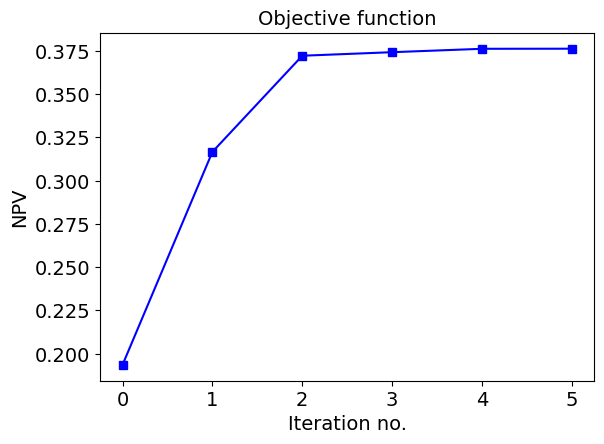

In [10]:
plot_obj_func()

<font size=4em>Example using the sequential Monte Carlo method. Here we also save the best state (which is not the mean of the ensemble simulations) and the corresponding best objective function value: 

In [11]:
ko_smc = deepcopy(ko)
ko_smc['savedata'] += ["best_state", "best_func"]
print(SmcOpt.__init__.__doc__)
SmcOpt(ensemble.function, x0, args=(cov,), sens=ensemble.calc_ensemble_weights, bounds=bounds, **ko_smc)


        Parameters
        ----------
            fun: callable
                objective function

            x: ndarray
                Initial state

            sens: callable
                Ensemble sensitivity

            bounds: list, optional
                (min, max) pairs for each element in x. None is used to specify no bound.

            options: dict
                Optimization options

                - maxiter: maximum number of iterations (default 10)
                - restart: restart optimization from a restart file (default false)
                - restartsave: save a restart file after each successful iteration (defalut false)
                - tol: convergence tolerance for the objective function (default 1e-6)
                - alpha: weight between previous and new step (default 0.1)
                - alpha_maxiter: maximum number of backtracing trials (default 5)
                - resample: number indicating how many times resampling is tried if no improv

2023-11-28 10:10:38,941 : INFO : popt.loop.optimize :        ====== Running optimization - SmcOpt ======
2023-11-28 10:10:38,942 : INFO : popt.loop.optimize : 
{'alpha': 0.2,
 'alpha_maxiter': 3,
 'beta': 0.1,
 'datatype': ['fopt', 'fgpt', 'fwpt', 'fwit'],
 'hessian': False,
 'inflation_factor': 10,
 'maxiter': 5,
 'nesterov': True,
 'optimizer': 'GA',
 'resample': 0,
 'restart': False,
 'restartsave': True,
 'savedata': ['alpha', 'obj_func_values', 'best_state', 'best_func'],
 'tol': 1e-06}
2023-11-28 10:10:38,942 : INFO : popt.loop.optimize :        iter       alpha_iter obj_func        step-size       
2023-11-28 10:10:38,943 : INFO : popt.loop.optimize :        0                     -1.9349e-01    
2023-11-28 10:10:48,383 : INFO : popt.loop.optimize :        1          0          -3.6301e-01     2.00e-01       
2023-11-28 10:10:58,212 : INFO : popt.loop.optimize :        2          0          -3.7386e-01     2.00e-01       
2023-11-28 10:11:07,416 : INFO : popt.loop.optimize :     

<font size=4em>Plot the objective function using the function defined above:

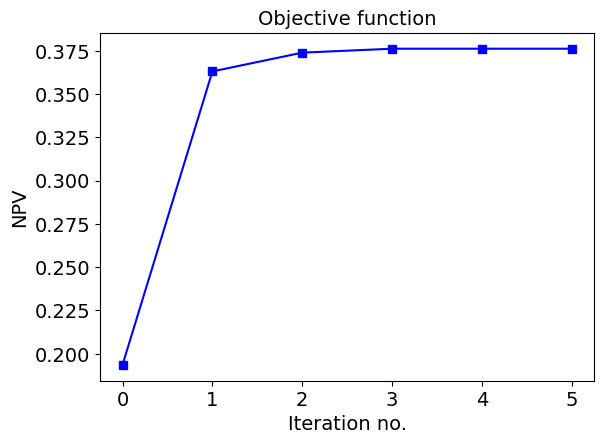

In [12]:
plot_obj_func()

<font size=4em>Example using ensemble gradient approximation with the conjugate gradient (CG) method from scipy.minimize: 

In [13]:
res = minimize(ensemble.function, x0, args=(cov,), method='CG', jac=ensemble.gradient, tol=ko['tol'],
               callback=ot.save_optimize_results, bounds=bounds, options=ko)
print(res)

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: -0.3561737322262323
       x: [ 5.385e-01  4.052e-01 -8.395e-02]
     nit: 4
     jac: [ 6.494e-04 -8.862e-04  4.442e-03]
    nfev: 60
    njev: 49


<font size=4em>Example calling EnOpt through scipy.minimize (this does exactly the same as running EnOpt, but with a different random seed since we do not reset the seed):

In [14]:
for file in glob('optimize_result_*'):
    os.remove(file)
minimize(ensemble.function, x0, args=(cov,), method=EnOpt, jac=ensemble.gradient, hess=ensemble.hessian,
         bounds=bounds, options=ko)

2023-11-28 10:19:11,409 : INFO : popt.loop.optimize :        ====== Running optimization - EnOpt ======
2023-11-28 10:19:11,410 : INFO : popt.loop.optimize : 
{'alpha': 0.2,
 'alpha_maxiter': 3,
 'beta': 0.1,
 'callback': None,
 'constraints': (),
 'datatype': ['fopt', 'fgpt', 'fwpt', 'fwit'],
 'hessian': False,
 'hessp': None,
 'inflation_factor': 10,
 'maxiter': 5,
 'nesterov': True,
 'optimizer': 'GA',
 'resample': 0,
 'restart': False,
 'restartsave': True,
 'savedata': ['alpha', 'obj_func_values'],
 'tol': 1e-06}
2023-11-28 10:19:11,410 : INFO : popt.loop.optimize :        iter       alpha_iter obj_func        step-size       cov[0,0]        
2023-11-28 10:19:11,410 : INFO : popt.loop.optimize :        0                     -1.9349e-01    
2023-11-28 10:19:20,961 : INFO : popt.loop.optimize :        1          0          -3.1062e-01     2.00e-01        3.90e-02       
2023-11-28 10:19:30,273 : INFO : popt.loop.optimize :        2          0          -3.5852e-01     2.00e-01       

<font size=4em>Plot the objective function using the function defined above:

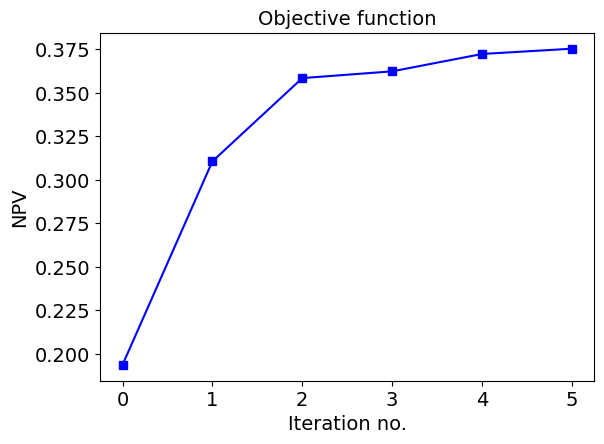

In [15]:
plot_obj_func()

## Setting up the .mako file
<font size=4em>The optimization relies on a .mako file for writing the current control variables to the flow simulator input. In this case, the flow simulator is opm-flow [opm-projects.org](opm-projects.org), and the input file is provided as a text file (.DATA file). The .mako file is created by replacing the keywords <span style="font-family:Courier;">WCONINJE</span> and <span style="font-family:Courier;">WCONPROD</span> in the .DATA file with: 
    
    WCONINJE
    'INJ-1'  WATER 'OPEN' BHP 2* ${injbhp[0]} /
    'INJ-2'  WATER 'OPEN' BHP 2* ${injbhp[1]} /
    /

    WCONPROD
     'PRO-1' 'OPEN' BHP 5* ${prodbhp[0]} /
    /


## Running locally

<font size=4em>It is recommended to run the notebook from a virtual environment. Follow these steps to run this notebook on your own computer: 
    
<font size=4em>*Step 1: Create virtual environment as normal*

    python3 -m venv pet_venv

<font size=4em>Then activate the environment using:

    source pet_venv/bin/activate

<font size=4em>*Step 2: Install Jupyter Notebook into virtual environment*

    python3 -m pip install ipykernel

<font size=4em>*Step 3: Install PET in the virtual environment, see [PET installation](https://github.com/Python-Ensemble-Toolbox/PET)*

<font size=4em>*Step 4: Allow Jupyter access to the kernel within the virtual environment*

    python3 -m ipykernel install --user --name=pet_venv

<font size=4em>Start jupyter notebook, and load tutorial_popt.ipynb (this file). On the jupyter notebook toolbar, select ‘Kernel’ and ‘Change Kernel’. The new kernel is now be available in the list for selection:
    
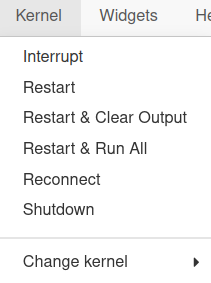